# Лабораторная работа №8. Сверточные нейронные сети (CNN). Компьютерное зрение. Задача классификации изображений


ЗАДАНИЕ №1.
1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Выполните как минимум две аугментации.
3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.
4. Сформулируйте вывод на основе ответов следующих вопросов:
- Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?
- Что означают параметры, которые Вы задаете?
- Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?


ЗАДАНИЕ №2.
1. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip Выберите 3 любых класса, которые Вам нравятся. Загрузите данные и сформируете датасет.
2. Выполните как минимум две аугментации.
3. С помощью фреймворка Tensorflow загрузите модели InceptionV3 и VGG19. Выполните Transfer Learning и Fine-Tuning этих моделей для распознавания классов. В процессе подготовки CNN, разморозьте какой-либо еще слой, кроме последнего. Сравните ре-зультаты двух моделей CNN на Ваших данных (по метрике accuracy в процессе обучения).
4. Реализуйте сверточный слой (прямое и обратное распространение). Используйте реализацию многослойного персептрона из ЛР №7. Соберите CNN, используя разработанные Вами слои.
5. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации CNN.


ЗАДАНИЕ №3**
Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, VGG19
import tensorflow as tf
from tensorflow.keras import layers, models
import zipfile
import os
import shutil
import tarfile
from PIL import Image
import splitfolders
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models

## Задание №1

1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Выполните как минимум две аугментации.
3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.
4. Сформулируйте вывод на основе ответов следующих вопросов:
- Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?
- Что означают параметры, которые Вы задаете?
- Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?

### 1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "C:\MLforGIt\ML_Labs\data\data3\data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


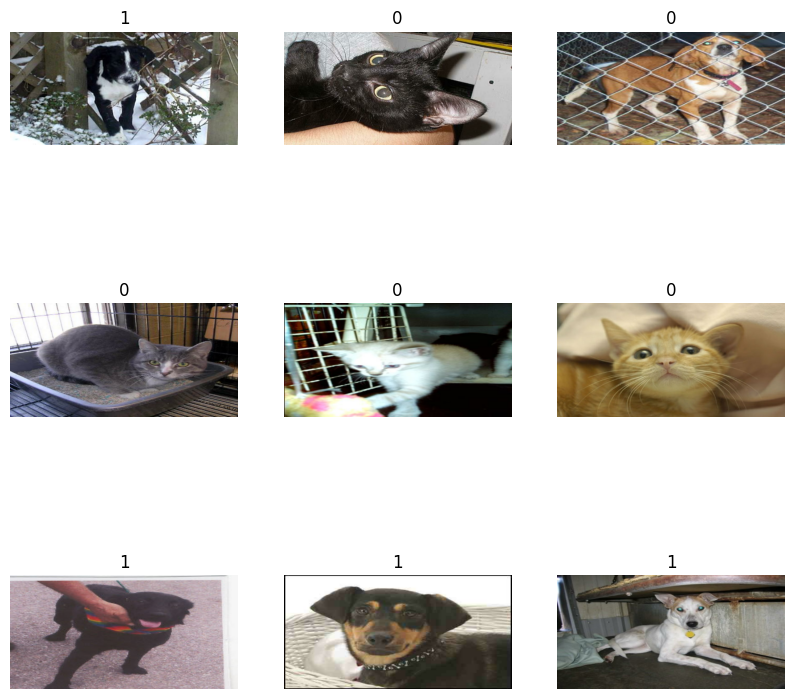

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### 2. Выполните как минимум две аугментации.

In [4]:
data_augmentation = Sequential(
    [
        #поворот и отражение
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #добавление шума
        layers.GaussianNoise(0.1) 
    ]
)

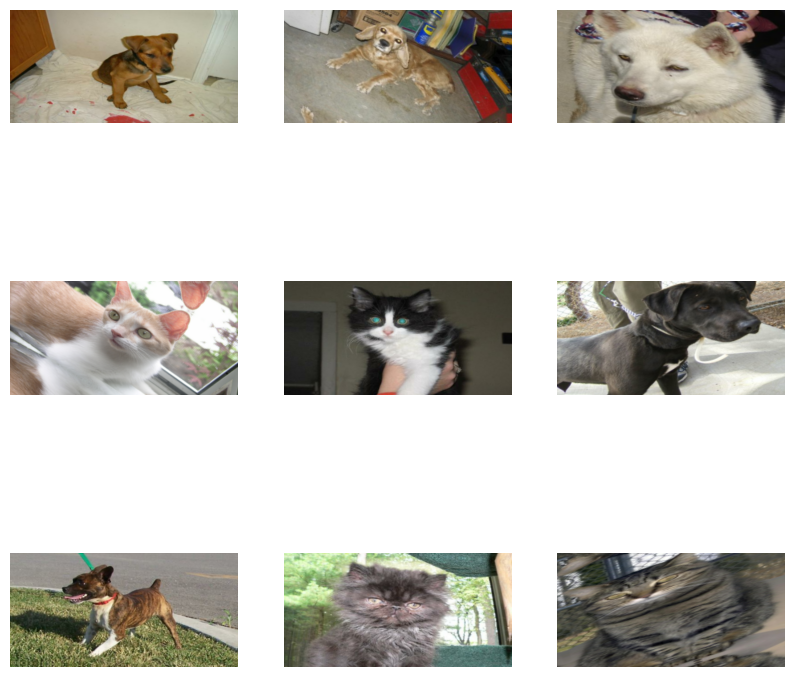

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

### 3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.

In [7]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


50/50 [==============================] - 24s 454ms/step - loss: 0.9672 - accuracy: 0.5375 - val_loss: 0.6920 - val_accuracy: 0.5550
Epoch 2/5
50/50 [==============================] - 23s 457ms/step - loss: 0.6831 - accuracy: 0.5875 - val_loss: 0.6223 - val_accuracy: 0.6475
Epoch 3/5
50/50 [==============================] - 23s 459ms/step - loss: 0.6522 - accuracy: 0.6144 - val_loss: 0.6413 - val_accuracy: 0.6175
Epoch 4/5
50/50 [==============================] - 23s 451ms/step - loss: 0.6359 - accuracy: 0.6569 - val_loss: 0.5829 - val_accuracy: 0.6675
Epoch 5/5
50/50 [==============================] - 24s 467ms/step - loss: 0.6200 - accuracy: 0.6631 - val_loss: 0.5465 - val_accuracy: 0.7225


In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("Точность на тестовых данных:", test_acc)

 1/13 [=>............................] - ETA: 1s - loss: 0.5850 - accuracy: 0.7188

13/13 [==============================] - 1s 67ms/step - loss: 0.5465 - accuracy: 0.7225
Точность на тестовых данных: 0.7225000262260437


In [11]:
def output(x):
    if x==0: return "Кот"
    else: return "Собака"

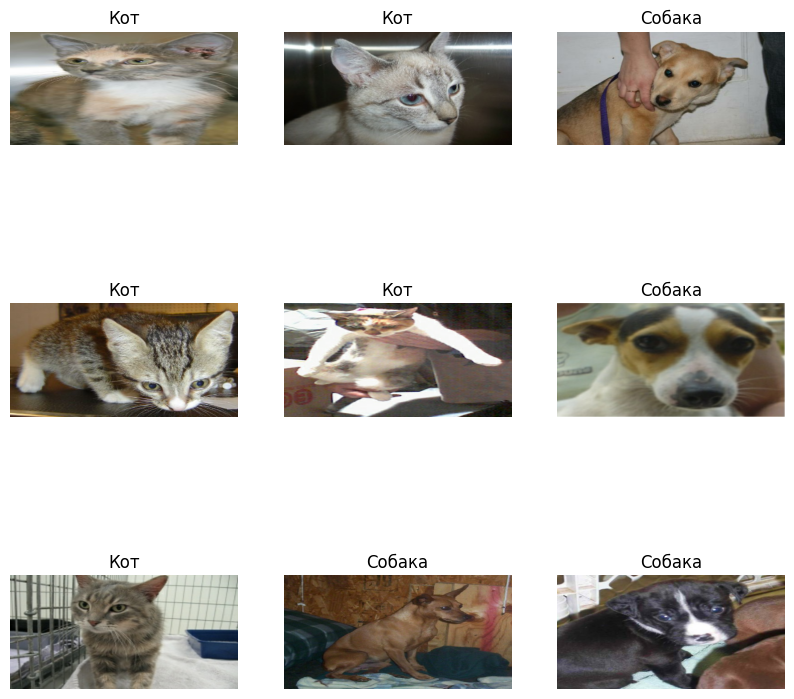

In [12]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in test_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(output(int(labels[i])))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

### 4. Сформулируйте вывод на основе ответов следующих вопросов:
Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?:
1. Было произведено разделение на выборки
2. Была произведена аугментаци: поворот и зашумление изображения
3. Масштабирование изображения до определенного размера
   
Что означают параметры, которые Вы задаете?
1. batch_size - кол-во образцов передаваемых за одну итерацию
2. epochs - количество итераций
3. validation_split - процент на тест
4. image_size - размер изображения
5. seed - сид генератор случайных чисел
6. subset - выбор типа выборки (тестовая, тренировочная, тестовая и тренировочная)
   
Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?

1. Conv2D - Сверточный слой, обрабатывающий изображения с использованием фильтров для выделения определенных признаков.
2. Activation - Слой активации, применяющий функцию активации (например, ReLU) к выходам сверточных слоев.
3. MaxPooling2D - Пулинг слой, уменьшающий размерность данных путем выбора максимального значения из набора.
4. Flatten - Преобразует выходы пулинг слоя в одномерный вектор перед подачей в полносвязанные слои.
5. Dense - Полносвязанный слой, который соединяет каждый нейрон с каждым нейроном предыдущего слоя.

## Задание №2

1. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip Выберите 3 любых класса, которые Вам нравятся. Загрузите данные и сформируете датасет.
2. Выполните как минимум две аугментации.
3. С помощью фреймворка Tensorflow загрузите модели InceptionV3 и VGG19. Выполните Transfer Learning и Fine-Tuning этих моделей для распознавания классов. В процессе подготовки CNN, разморозьте какой-либо еще слой, кроме последнего. Сравните ре-зультаты двух моделей CNN на Ваших данных (по метрике accuracy в процессе обучения).
4. Реализуйте сверточный слой (прямое и обратное распространение). Используйте реализацию многослойного персептрона из ЛР №7. Соберите CNN, используя разработанные Вами слои.
5. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации CNN.

In [13]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "C:\MLforGIt\ML_Labs\data\caltech-101\data", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 216 files belonging to 3 classes.
Using 184 files for training.
Using 32 files for validation.


In [14]:
data_augmentation = Sequential(
    [
        #поворот и отражение
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #добавление шума
        layers.GaussianNoise(0.1) 
    ]
)

In [15]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

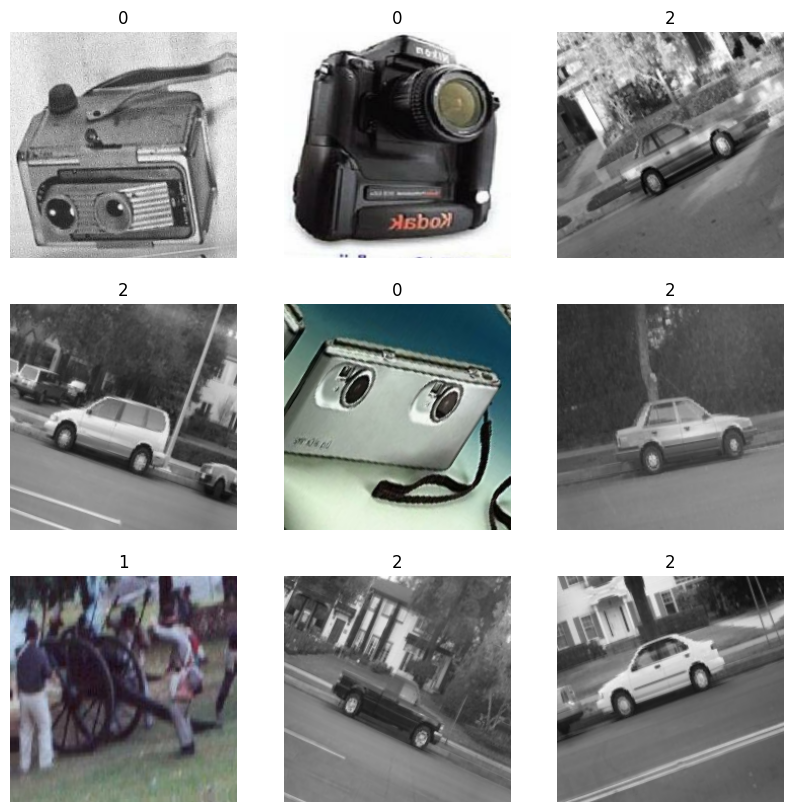

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

### VGA19

In [17]:
vgg = VGG19(weights='imagenet', include_top=False)

In [18]:
for layer in vgg.layers[:-4]:
    layer.trainable = False

x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=vgg.input, outputs=predictions)

In [19]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
vgg_model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
6/6 [==============================] - 35s 6s/step - loss: 8.5847 - accuracy: 0.4783 - val_loss: 1.1522 - val_accuracy: 0.2500
Epoch 2/5
6/6 [==============================] - 36s 6s/step - loss: 1.8307 - accuracy: 0.3859 - val_loss: 1.1836 - val_accuracy: 0.5938
Epoch 3/5
6/6 [==============================] - 38s 6s/step - loss: 1.4201 - accuracy: 0.5054 - val_loss: 1.0985 - val_accuracy: 0.5938
Epoch 4/5
6/6 [==============================] - 45s 8s/step - loss: 2.1304 - accuracy: 0.3696 - val_loss: 1.5110 - val_accuracy: 0.5938
Epoch 5/5
6/6 [==============================] - 60s 10s/step - loss: 1.4708 - accuracy: 0.5652 - val_loss: 1.0690 - val_accuracy: 0.5938


### InceptionV3

In [21]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [22]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
inception_model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
inception_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
inception_model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
6/6 [==============================] - 23s 2s/step - loss: 130.0096 - accuracy: 0.4891 - val_loss: 43.2331 - val_accuracy: 0.7812
Epoch 2/5
6/6 [==============================] - 8s 1s/step - loss: 34.7960 - accuracy: 0.5870 - val_loss: 7.5718 - val_accuracy: 0.7500
Epoch 3/5
6/6 [==============================] - 8s 1s/step - loss: 19.0098 - accuracy: 0.6685 - val_loss: 7.3698 - val_accuracy: 0.8125
Epoch 4/5
6/6 [==============================] - 8s 1s/step - loss: 7.7736 - accuracy: 0.7663 - val_loss: 0.9644 - val_accuracy: 0.9062
Epoch 5/5
6/6 [==============================] - 8s 1s/step - loss: 6.2243 - accuracy: 0.7772 - val_loss: 3.9075 - val_accuracy: 0.8438


InceptionV3 отработало гораздо лучше